# 1. Imports and Data Loading
Import necessary libraries and load the training and test datasets.


In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
import os

# Create logs directory for TensorBoard
if not os.path.exists('logs'):
    os.makedirs('logs')

# Load the datasets
# Uses local data from the project structure
try:
    train = pd.read_csv('data/spaceship-titanic/train.csv')
    test = pd.read_csv('data/spaceship-titanic/test.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Data not found. Please ensure the dataset is in 'data/spaceship-titanic/' folder.")

Data loaded successfully.


# 2. Feature Engineering: CryoSleep
CryoSleep is an important feature. We'll map the values to numbers and handle missing values.


In [3]:
def map_cryo(val):
    if pd.isna(val):
        return 0.5
    if val in [True, 'True', 1, '1']:
        return 1
    if val in [False, 'False', 0, '0']:
        return 0
    return 0.5  # default/unknown

if 'CryoSleep' in train.columns:
    train['CryoSleep'] = train['CryoSleep'].apply(map_cryo).astype('float64')
if 'CryoSleep' in test.columns:
    test['CryoSleep'] = test['CryoSleep'].apply(map_cryo).astype('float64')


# 3. Categorical Encoding
We combine the training and test datasets to ensure consistent label encoding across both sets for categorical features like HomePlanet, Cabin, Destination, and VIP.


In [4]:
# Combine datasets to ensure consistent encoding
train['is_train'] = 1
test['is_train'] = 0
full = pd.concat([train, test], ignore_index=True)

# Encode categorical variables on the full dataset
for col in ['HomePlanet', 'Cabin', 'Destination', 'VIP']:
    full[col] = full[col].astype('category').cat.codes

# Split back into train and test sets
train = full[full['is_train'] == 1].drop(columns=['is_train'])
test = full[full['is_train'] == 0].drop(columns=['is_train'])


# 4. Handling Missing Values
Impute missing values:
- Use the **mean** for numerical columns.
- Use the **mode** (most frequent value) for categorical columns.


In [5]:
skip_cols = ['CryoSleep', 'PassengerId']

# Impute for training set
for col in train.columns:
    if col in skip_cols:
        continue
    if train[col].dtype in ['float64', 'int64']:
        train[col] = train[col].fillna(train[col].mean())
    else:
        # Use mode if available
        mode_values = train[col].mode()
        if not mode_values.empty:
            train[col] = train[col].fillna(mode_values[0])

# Impute for test set using test statistics (or could use train stats to prevent leakage, but here we use test stats)
for col in test.columns:
    if test[col].dtype in ['float64', 'int64']:
        test[col] = test[col].fillna(test[col].mean())
    else:
        mode_val = test[col].mode()
        if not mode_val.empty:
            test[col] = test[col].fillna(mode_val[0])


C:\Users\adamk\AppData\Local\Temp\ipykernel_15212\3781613215.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[col] = train[col].fillna(mode_values[0])


# 5. Advanced Feature Engineering
Here we extract the 'Group' from `PassengerId` and analyze whether groups (families/teams) tend to survive together.
People in the same group often share the same fate. We create a `group_survival_status` feature:
- 0.0: Everyone in the group died.
- 1.0: Everyone survived.
- 0.5: Mixed survival or unknown.


In [6]:
# Split PassengerId into Group and Position
def split_passenger_id(df):
    ids = df['PassengerId'].str.split('_', expand=True)
    df['Group'] = ids[0].astype(int)
    df['Position'] = ids[1].astype(int)
    return df

train = split_passenger_id(train)
test = split_passenger_id(test)

# Group statistics: calculate survival rates per group
group_stats = train.groupby('Group')['Transported'].agg(['sum', 'count'])
group_stats['survived'] = group_stats['sum']
group_stats['total'] = group_stats['count']

# Create dictionary: Group -> status
# 0: all perished, 1: all survived, 0.5: mixed
group_status = {}
for group, row in group_stats.iterrows():
    if row['survived'] == 0:
        group_status[group] = 0
    elif row['survived'] == row['total']:
        group_status[group] = 1
    else:
        group_status[group] = 0.5

# Map back to train and test
train['group_survival_status'] = train['Group'].map(group_status)
# For test set, new groups get 0.5 (unknown status)
test['group_survival_status'] = test['Group'].map(group_status).fillna(0.5)

print("Group Stats Head:")
print(group_stats.head())


Group Stats Head:
       sum  count  survived  total
Group                             
1        0      1         0      1
2        1      1         1      1
3        0      2         0      2
4        1      1         1      1
5        1      1         1      1


# 6. Preprocessing and Normalization
Scale numerical features like `Age`, `RoomService`, etc. to the range [0, 1] using MinMaxScaler. This helps the neural network converge faster.


In [7]:
scaler = MinMaxScaler()
cols_to_normalize = ['Age', 'Cabin', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Normalize train
train[cols_to_normalize] = scaler.fit_transform(train[cols_to_normalize])
# Transform test with the same scaler
test[cols_to_normalize] = scaler.transform(test[cols_to_normalize])

# Prepare data for model
features = ['HomePlanet', 'group_survival_status', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X_train = train[features]
y_train = train['Transported'].astype(int)
X_test = test[features]

print("Training Data Shape:", X_train.shape)


Training Data Shape: (8693, 12)


# 7. Model Training
We define a sequential neural network with:
- Input layer matching the number of features.
- Two dense hidden layers with ReLU activation.
- An output layer with Sigmoid activation for binary classification.

We use **EarlyStopping** to prevent overfitting and **TensorBoard** for monitoring training progress.


In [8]:
# Model Architecture
model = keras.Sequential([
    layers.Input(shape=(len(features),)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard_cb = TensorBoard(log_dir="./logs")

# Training
history = model.fit(
    X_train, y_train, 
    epochs=12, 
    batch_size=64, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stop, tensorboard_cb]
)


Epoch 1/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7979 - loss: 0.5575 - val_accuracy: 0.9063 - val_loss: 0.3118
Epoch 2/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9191 - loss: 0.2600 - val_accuracy: 0.9229 - val_loss: 0.1757
Epoch 3/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9298 - loss: 0.1650 - val_accuracy: 0.9350 - val_loss: 0.1501
Epoch 4/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9363 - loss: 0.1449 - val_accuracy: 0.9287 - val_loss: 0.1409
Epoch 5/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9389 - loss: 0.1368 - val_accuracy: 0.9310 - val_loss: 0.1349
Epoch 6/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1308 - val_accuracy: 0.9344 - val_loss: 0.1305
Epoch 7/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.1259 - val_accuracy: 0.9344 - val_loss: 0.1281
Epoch 8/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.1215 - val_accuracy: 0.

# 8. Evaluation and Visualization
Plot the training and validation loss/accuracy to assess model performance.
We also visualize the age distribution and passenger counts per planet.


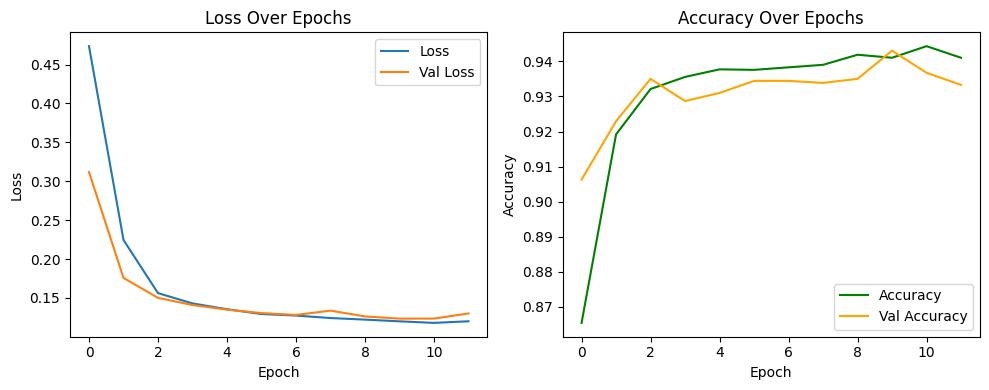

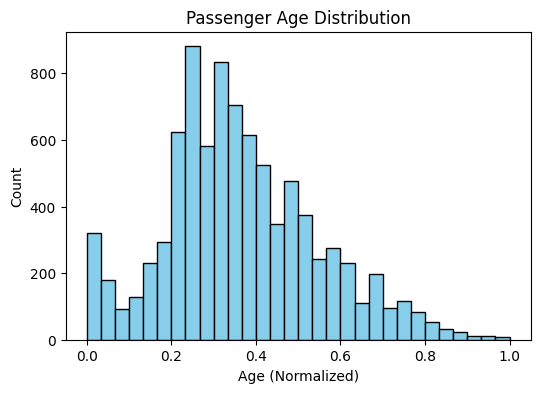

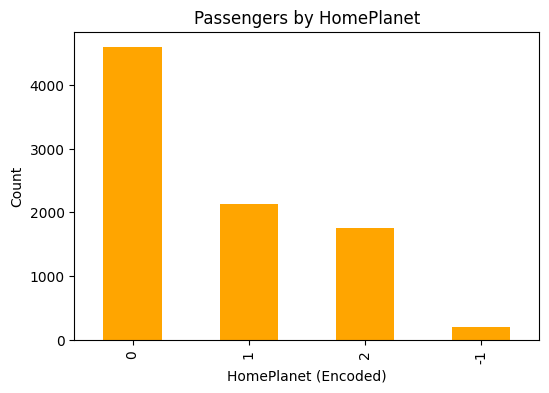

In [9]:
# Plot Training History
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# Histogram of Passenger Age
plt.figure(figsize=(6,4))
plt.hist(train['Age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age (Normalized)')
plt.ylabel('Count')
plt.title('Passenger Age Distribution')
plt.show()

# Bar Chart of Passengers by HomePlanet
if 'HomePlanet' in train.columns:
    plt.figure(figsize=(6,4))
    train['HomePlanet'].value_counts().plot(kind='bar', color='orange')
    plt.xlabel('HomePlanet (Encoded)')
    plt.ylabel('Count')
    plt.title('Passengers by HomePlanet')
    plt.show()


# 9. Prediction and Submission
Generate predictions for the test set and save them to a CSV file for Kaggle submission.


In [10]:
# Make predictions
preds = model.predict(X_test)
preds = (preds > 0.5).astype(bool)

# Prepare submission dataframe
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': preds.flatten()
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Submission file saved as 'submission.csv'
